#### Continual Learning Tutorial

In this notebook, we'll show how to use `laplax` in a simple continual learning context. We'll first show that by just continuing to train on new data distributions, we "forget" past distributions. Then, we'll briefly introduce a certain flavour of curvature matrix, before giving a concise implementation. Finally, we'll discuss the trade-off between stability and plasticity which is offered by the simple regularization method.

In [1]:
from laplax.util.datasets import mnist, minimnist, permute, DataLoader, collect
from typing import *
from flax import nnx


"""
    We're training on minimnist, which is a small subset of MNIST.
    If you want to use the full MNIST dataset, you can use the `mnist` function instead.
"""

trainloader, testloader, num_train, num_test = minimnist()

class MLP(nnx.Module):
    def __init__(self, rngs : nnx.Rngs, in_size: int= 28*28, hidden_size: int=10, num_classes:int=10):
        super().__init__()
        self.hidden1 = nnx.Linear(in_features=in_size, out_features=hidden_size, rngs=rngs)
        self.hidden2 = nnx.Linear(in_features=hidden_size, out_features=hidden_size, rngs=rngs)
        self.hidden3 = nnx.Linear(in_features=hidden_size, out_features=num_classes, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.hidden1(x))
        x = nnx.relu(self.hidden2(x))
        x = self.hidden3(x)
        return x


[MiniMNIST] Loading from cache...


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree as jt
import optax

In [3]:
@nnx.jit
def update(model, optimizer, x, y):
    def cross_entropy(model, x, y):
        logits = model(x)
        ypred = jax.nn.log_softmax(logits)
        loss = -(ypred * y).mean()
        return loss
    loss, grads = nnx.value_and_grad(cross_entropy)(model, x, y)
    optimizer.update(grads)
    return loss

def evaluate(model : nnx.Module, _loader : DataLoader, seeds : Sequence[int]):
    """
        Evaluates a model on a set of permuted dataloaders. Note: seed=0 is the non-permuted dataloader.
    """
    ret = []
    for seed in seeds:
        correct = 0
        loader = permute(_loader, seed=seed)
        for x, y in loader:
            logits = model(x)
            preds = jnp.argmax(logits, axis=-1)
            correct += jnp.sum(jnp.argmax(y, axis=-1) == preds)
        ret.append(correct / loader.num_samples)
    return ret

def train_epoch(model, optimizer, trainloader):
    loss_history = []
    for x, y in trainloader:
        loss = update(model, optimizer, x, y)
        loss_history.append(loss)
    return loss_history

def train(model, optimizer, trainloader, testloader, eval_seeds, num_epochs=10, evaluate=False):
    """
        Train the model for a number of epochs, evaluating on the test set for eval_seeds at the end of each epoch.
    """
    history = []
    for epoch in range(1, num_epochs + 1):
        losses = train_epoch(model, optimizer, trainloader)
        history.extend(losses)
        if evaluate and epoch % 10 == 0:
            test_accuracy = evaluate(model, testloader, seeds=eval_seeds)
            print(f"Epoch {epoch}/{num_epochs}, ",
                  f"Test Accuracy: {test_accuracy}")
            
    return model, optimizer, history



In [4]:
model = MLP(rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model=model, tx = optax.adamw(learning_rate=1e-4, weight_decay=5e-4))
model, optimizer, history = train(model, optimizer, trainloader, testloader, 
                                  num_epochs=100, eval_seeds=[0], evaluate=False)
accuracy = evaluate(model, testloader, seeds=[0])
print(f"Test-Accuracy on MNIST without permutation: {accuracy}")

Test-Accuracy on MNIST without permutation: [Array(0.87785715, dtype=float32)]


Sanity check passed. We trained on a subset of mnist and got ~87% accuracy with a three-layer MLP

#### Continual Learning

We're permuting the inputs while keeping the labels static:

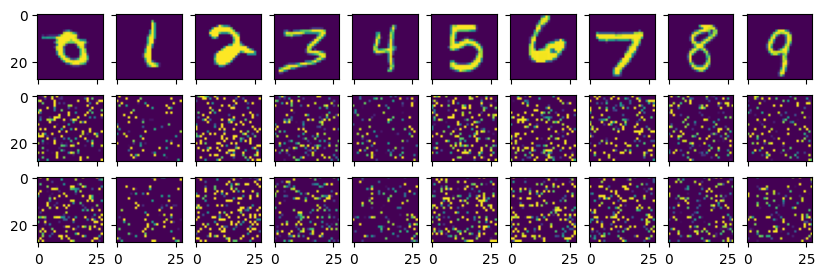

In [5]:
# make simple plot which shows one sample of the training data (MNIST number) and its permutation in the next row
import matplotlib.pyplot as plt
def split_loader(loader):
    X, y = loader.X, jnp.argmax(loader.y, axis=-1)
    xs = [X[y==i] for i in range(10)]
    return xs

seeds = [0, 1, 2]
imgs = []
for seed in seeds:
    xs = split_loader(permute(testloader, seed=seed))
    imgs.extend([x[0].reshape(28, 28) for x in xs]) # take first sample

fig, axs = plt.subplots(3, 10, figsize=(10, 3), sharex=True, sharey=True)
axs = axs.flatten()

for img, ax in zip(imgs, axs):
    ax.imshow(img)

#### Continual Learning Primer

In the MNIST Permute setup, we're continuously training on permuted samples from MNIST. Whilst the training
data distribution changes, we're keeping track of performance on past distributions to measure the *plasticity* - i.e. the ability to adapt and learn new information over time - and the *stability* - i.e. the ability to retain information about past training data - of the model. 

In this notebook, we want to understand the influence of regularizers on the stability and plasticity of Neural Networks. First, let us see the influence on the stability with no regularization.

In [6]:
task_seeds = jnp.arange(5) # we want 5 different "tasks" - they correspond to permutations of the initial MNIST
model = MLP(rngs=nnx.Rngs(0)) # initilalize the model once
optimizer = nnx.Optimizer(model=model, tx = optax.adamw(learning_rate=1e-4, weight_decay=5e-4))
loss_history, previous_accuracies = [], []

for i, seed in enumerate(task_seeds):
    cur_trainloader = permute(trainloader, seed=seed)
    model, optimizer, history = train(model, optimizer, cur_trainloader, testloader, 
              num_epochs=100, eval_seeds=task_seeds[:i+1], evaluate=False)
    acc = evaluate(model, testloader, seeds=task_seeds[:i+1])
    loss_history.extend(history); previous_accuracies.append(acc)
    

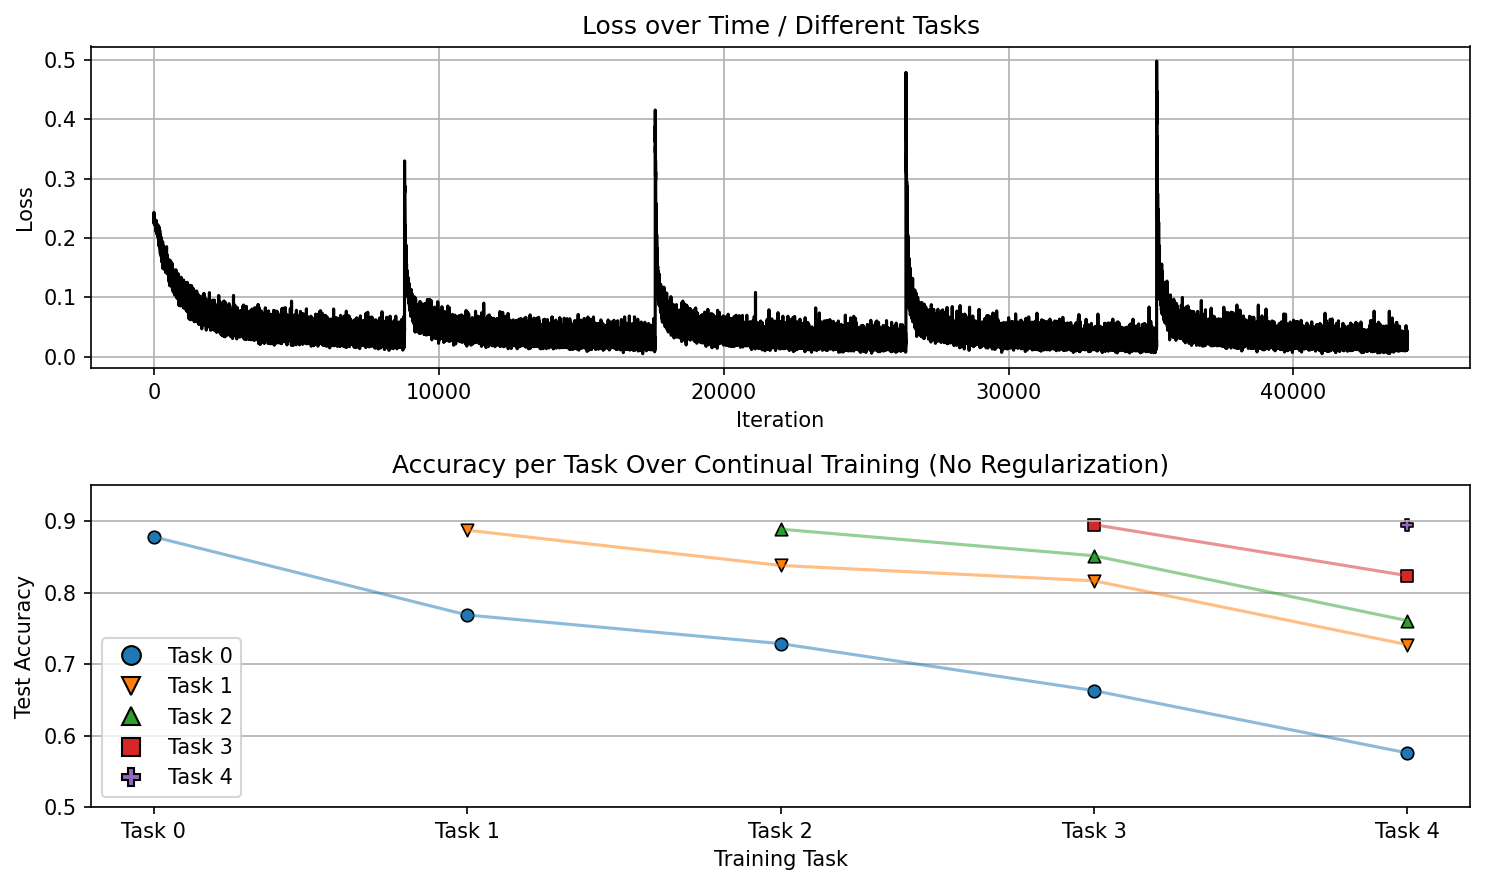

In [7]:
from copy import deepcopy

def plot(accuracies, history, title, task_seeds=None):
    tmp = deepcopy(accuracies)
    num_tasks = 5 if task_seeds is None else len(task_seeds)
    transposed_accuracies = [[l.pop(0) for l in tmp if len(l) > 0] for _ in range(num_tasks)]

    # Use higher DPI for better quality
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), dpi=150)

    # --- Loss plot ---
    ax1.plot(history, color='black')
    ax1.set_title("Loss over Time / Different Tasks")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Iteration")
    ax1.grid(True)

    # --- Accuracy plot ---
    markers = ["o", "v", "^", "s", "P"]
    colors = plt.colormaps.get_cmap('tab10')

    for i, task_accs in enumerate(transposed_accuracies):
        xpos = list(range(i, len(transposed_accuracies)))
        ax2.plot(xpos, task_accs, color=colors(i), alpha=0.5)
        ax2.scatter(xpos, task_accs, marker=markers[i], facecolor=colors(i), edgecolor='black', linewidth=0.8)

    # Custom legend
    handles = [
        plt.Line2D(
            [0], [0], marker=markers[i], color='w', label=f'Task {i}',
            markerfacecolor=colors(i), markeredgecolor='black', markersize=9
        ) for i in range(num_tasks)
    ]
    ax2.legend(handles=handles, loc='lower left')

    ax2.grid(True, axis='y')
    ax2.set_title(title)
    ax2.set_ylabel('Test Accuracy')
    ax2.set_xlabel("Training Task")

    # Set xticks according to the number of tasks
    xticks = list(range(len(transposed_accuracies)))
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([f'Task {i}' for i in xticks])
    ax2.set_ylim(0.5, 0.95)
    plt.tight_layout()
    plt.show()

plot(previous_accuracies, loss_history, title='Accuracy per Task Over Continual Training (No Regularization)')

#### Discussion and where to go next 

We can see that the performance for previous tasks when continuously training the model without any regularization drops. The current task however is always learned. We can notice that we might be able to trade off plasticity for stability - this is what we'll try to do next: We will approximate the curvature around the found mode using the empirical Fisher and use this information as a regularizer for the downstream tasks. We will show that even with a simple diagonal approximation to curvature we can retain most of the plasticity while gaining a lot of stability in our setup.

The new loss formulation is:

$$
    \mathcal L(\theta; \theta_{i-1}, x, y) = \texttt{CE}(\hat y, y) + (\theta_{i - 1} - \theta)^\top \Psi (\theta_{i - 1} - \theta)
$$

The regularization term re-scales the distance between the current and the previous sets of parameters by the curvature $\Psi$. Changes in the directions in parameter space with high curvature will incur a high loss - hence the regularization term induces a bias towards keeping a certain set of high curvature directions more static then others. After converging on each training task $i$, we will compute a function $\texttt{inner\_fn}$ which takes in the distance $d := \theta_{i - 1} - \theta_{i}$ and computes $d^\top\hat \Psi d$ where $\hat \Psi$ is an approximation to the true curvature.  

In [8]:
from laplax.util.tree import sub, dot   # pytree utiliy functions

def update(model, optimizer, x, y, mode, inner_fn, reg_lambda=1e-4):
    def cross_entropy(model, x, y):
        logits = model(x)
        ypred = jax.nn.log_softmax(logits)
        loss = -(ypred * y).mean()
        return loss
    
    def regularization(model):
        if not inner_fn:
            return 0.0
        
        _, params = nnx.split(model)
        d = sub(mode, params)
        reg = inner_fn(d) # this computes the scaled inner product
        return reg
    
    def total_loss(model, x, y):
        ce_loss = cross_entropy(model, x, y)
        reg_loss = regularization(model)
        return ce_loss + reg_lambda * reg_loss
    
    loss, grads = nnx.value_and_grad(total_loss)(model, x, y)
    optimizer.update(grads)
    return loss

def train(model, optimizer, trainloader, testloader, 
          eval_seeds, mode, inner_fn, 
          reg_lambda=1e-4, num_epochs=100, evaluate=False):
    """
        Train the model for a number of epochs, evaluating on the test set for eval_seeds at the end of each epoch.
    """
    history = []
    
    # recompile the update function when inner_fn changes
    jit_update = nnx.jit(update, static_argnames=('inner_fn')) 
    for epoch in range(1, num_epochs + 1):
        for x, y in trainloader:
            loss = jit_update(model=model, 
                               optimizer=optimizer, 
                               x=x, y=y,
                               mode=mode,
                               inner_fn=inner_fn, reg_lambda=reg_lambda)
            
            history.append(loss)

        if evaluate and epoch % 10 == 0:
            test_accuracy = evaluate(model, testloader, seeds=eval_seeds)
            print(f"Epoch {epoch}/{num_epochs}, ",
                  f"Test Accuracy: {test_accuracy}")
            
    return model, optimizer, history
                                                      

#### Defining the Inner Product $(\theta_{i - 1} - \theta)^\top \Psi (\theta_{i - 1} - \theta)$
Lets define a factory function, which given a current model mode ($\theta_i$) and a set of training samples, computes the $\texttt{inner\_fn}$ we will use in the regularization.

In [9]:
def emp_fisher_inner(model, trainloader, maxsamples, *args, **kwargs):
    """
    Computes the empirical Fisher information inner product function for a model.

    Args:
        model: The neural network model.
        trainloader: DataLoader providing training data.
        maxsamples: Number of samples to use from the loader.
        *args, **kwargs: Additional arguments (unused).

    Returns:
        inner: A function that computes the empirical Fisher inner product with a vector v.
    """
    def cross_entropy(model, x, y):
        log_y_pred = jax.nn.log_softmax(model(x))
        return -(log_y_pred * y).mean()

    xb, yb = collect(trainloader, maxsamples=maxsamples)
    grads = nnx.grad(cross_entropy)(model, xb, yb)
    sqgrads = jax.tree.map(lambda x: jnp.mean(x**2, axis=0), grads)  # square and mean

    def inner(v, sqgrads=sqgrads):
        return dot(v, jax.tree.map(lambda x, y: x * y, v, sqgrads))

    return inner

In [10]:
"""
   NOTE: In case you're running out of memory, use jax.clear_caches() in the loop 
""" 
model = MLP(rngs=nnx.Rngs(0))  # initialize the model once
optimizer = nnx.Optimizer(model=model,
                          tx=optax.adamw(learning_rate=1e-4, weight_decay=5e-4))

# these numbers I've found to be a good trade-off in a gridsearch
CURV_APPROX_SAMPLES = 128
LAMBDA = 1000
mode, inner_fn = nnx.split(model)[1], None
task_seeds = jnp.arange(5)
previous_accuracies, loss_history = [], []
for i, seed in enumerate(task_seeds):
   cur_trainloader = permute(trainloader, seed=seed)
   model, optimizer, history = \
   train(model=model,
         optimizer=optimizer,
         trainloader=cur_trainloader,
         testloader=testloader,
         eval_seeds=None,
         evaluate=False,
         mode=mode,
         inner_fn=inner_fn,
         reg_lambda=LAMBDA)
   acc = evaluate(model, testloader, seeds=task_seeds[:i+1])
   print(f"Task {i}, Test Accuracy: {acc}")
   previous_accuracies.append(acc)
   loss_history.extend(history)

   # post training: get new mode and compute the inner_fn
   mode = nnx.split(model)[1]
   inner_fn = emp_fisher_inner(model, cur_trainloader, 
                        maxsamples=CURV_APPROX_SAMPLES)
   



Task 0, Test Accuracy: [Array(0.87785715, dtype=float32)]
Task 1, Test Accuracy: [Array(0.8378571, dtype=float32), Array(0.8442857, dtype=float32)]
Task 2, Test Accuracy: [Array(0.82214284, dtype=float32), Array(0.8, dtype=float32), Array(0.8757143, dtype=float32)]
Task 3, Test Accuracy: [Array(0.75857145, dtype=float32), Array(0.77, dtype=float32), Array(0.8371429, dtype=float32), Array(0.8707143, dtype=float32)]
Task 4, Test Accuracy: [Array(0.72571427, dtype=float32), Array(0.73571426, dtype=float32), Array(0.8042857, dtype=float32), Array(0.8442857, dtype=float32), Array(0.8685714, dtype=float32)]


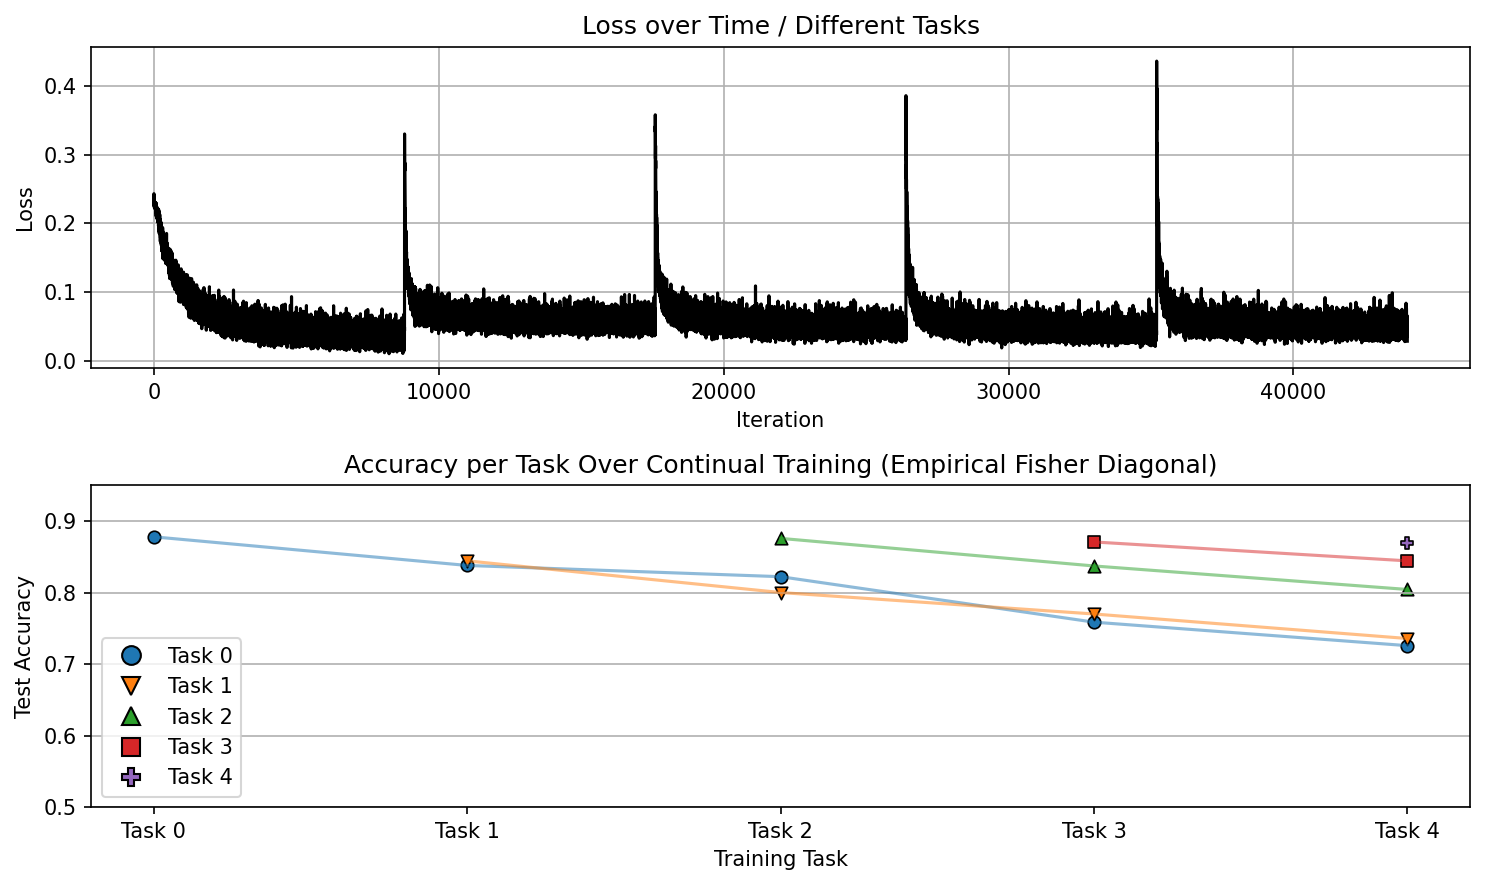

In [11]:
plot(previous_accuracies, loss_history, title='Accuracy per Task Over Continual Training (Empirical Fisher Diagonal)')

#### Discussion

As we can see by comparing both plots, the Empirical-Fisher-regularized version does perform quite well.

Currently, we're using a diagonal approximation to the Fisher, as building the full matrix may be quite expensive. We can however try to find an approximation which lies between the diagonal and full matrix, trading off computation and memory for performance. Common choices are a low-rank approximation or a Kroenecker Factored approximation to curvature (KFAC).

In [15]:
from laplax.experimental.innerprods import kfac_inner_fn

model = MLP(rngs=nnx.Rngs(0))  # initialize the model once
optimizer = nnx.Optimizer(model=model,
                          tx=optax.adamw(learning_rate=1e-4, weight_decay=5e-4))
graph_def, _ = nnx.split(model)

def model_fn(params, input):
    return nnx.call((graph_def, params))(input)[0]

# these numbers I've found to be a good trade-off in a gridsearch
CURV_APPROX_SAMPLES = 128
LAMBDA = .01
mode, inner_fn = nnx.split(model)[1], None
task_seeds = jnp.arange(5)
previous_accuracies, loss_history = [], []
for i, seed in enumerate(task_seeds):
   cur_trainloader = permute(trainloader, seed=seed)
   model, optimizer, history = \
   train(model=model,
         optimizer=optimizer,
         trainloader=cur_trainloader,
         testloader=testloader,
         eval_seeds=None,
         evaluate=False,
         mode=mode,
         inner_fn=inner_fn,
         reg_lambda=LAMBDA)
   acc = evaluate(model, testloader, seeds=task_seeds[:i+1])
   print(f"Task {i}, Test Accuracy: {acc}")
   previous_accuracies.append(acc)
   loss_history.extend(history)

   # post training: get new mode and compute the inner_fn
   _, params = nnx.split(model)
   x, y = collect(cur_trainloader, maxsamples=CURV_APPROX_SAMPLES)
   data = {'input' : x, 'target' : y}
   inner_fn = kfac_inner_fn(params=params, model_fn=model_fn, data=data)
   


Task 0, Test Accuracy: [Array(0.87785715, dtype=float32)]


/home/richard/github/laplax/laplax/experimental/innerprods.py:39: UserWarning: Current assumption is that the pytree structure puts bias                 before weights AND your model only consists of Linear Layers.
  warnings.warn(


Task 1, Test Accuracy: [Array(0.76857144, dtype=float32), Array(0.88714284, dtype=float32)]
Task 2, Test Accuracy: [Array(0.7285714, dtype=float32), Array(0.83928573, dtype=float32), Array(0.88785714, dtype=float32)]
Task 3, Test Accuracy: [Array(0.6571429, dtype=float32), Array(0.81785715, dtype=float32), Array(0.8485714, dtype=float32), Array(0.89428574, dtype=float32)]
Task 4, Test Accuracy: [Array(0.5807143, dtype=float32), Array(0.72571427, dtype=float32), Array(0.75714284, dtype=float32), Array(0.83, dtype=float32), Array(0.89357144, dtype=float32)]


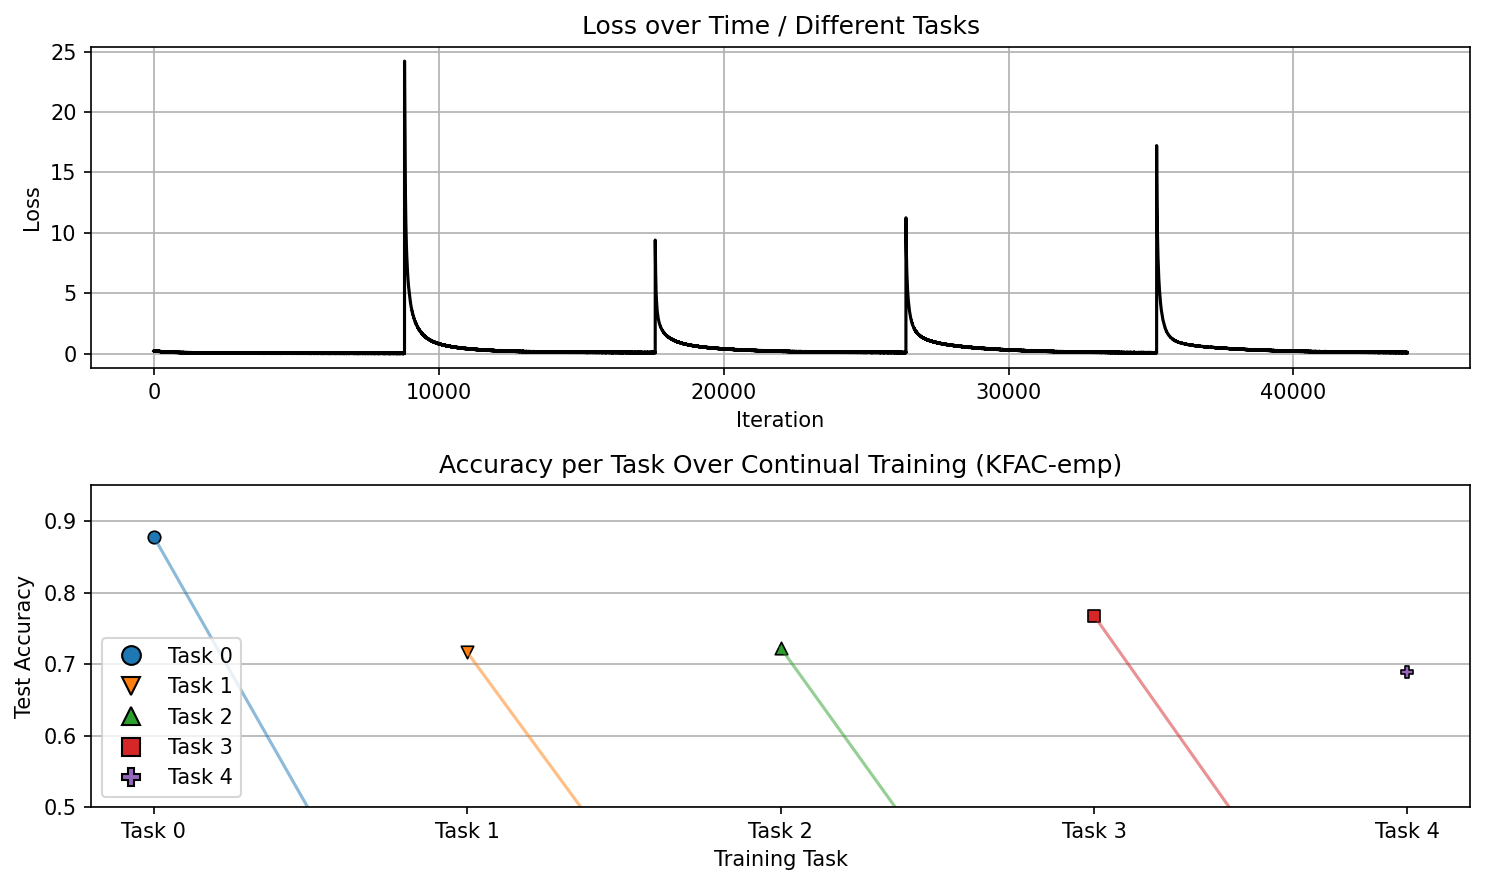

In [13]:
plot(previous_accuracies, loss_history , title='Accuracy per Task Over Continual Training (KFAC-emp)')